In [1]:
import numpy as np
import random
import traci
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import matplotlib.pyplot as plt
import math

from IPython.display import display, clear_output

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# Parameters

In [2]:
# SUMO configuration
SUMO_BINARY = "sumo"    # or "sumo-gui"
SUMO_CONFIG = "../config/my_simulation.sumocfg"

# Hyperparameters
GAMMA = 1 #0.99
ALPHA = 0.001                       # Learning rate
EPSILON = 0.1

REPLAY_BUFFER_SIZE = 100000         # Replay memory size
BATCH_SIZE = 32
TARGET_UPDATE = 20                  # Frequency to update the target network

NBR_EPISODES = 100
STEPS_PER_EPISODE = 1000

# Environment parameters
STATE_SIZE = 6
ACTION_SIZE = 2

## Neural Network architecture
Continuous state space for DQN

In [3]:
# Neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, batch_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, batch_size)
        self.fc2 = nn.Linear(batch_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Instantiate the main Q-network and target Q-network
policy_net = DQN(state_size=STATE_SIZE, action_size=ACTION_SIZE, batch_size=BATCH_SIZE)
target_net = DQN(state_size=STATE_SIZE, action_size=ACTION_SIZE, batch_size=BATCH_SIZE)

target_net.load_state_dict(policy_net.state_dict())     # Initialize with the same weights
target_net.eval()                                       # Target network should not be trained directly

# Optimizer & Loss function
optimizer = optim.Adam(policy_net.parameters(), lr=ALPHA)
loss_fn = nn.MSELoss()

# Replay buffer
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

# MDP

### Helper methods

In [5]:
def get_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)


def get_nearest_vehicle_distance(junction_id, edge_id):
    """
    Get the smallest distance between a junction (traffic light) and the nearest vehicle on a specific edge.

    Returns:
    - Smallest distance to the nearest vehicle or 150 if no vehicles are on the edge.
    """
    # Get the position of the junction
    junction_position = traci.junction.getPosition(junction_id)
    
    # Get the list of vehicle IDs on the specified edge
    vehicle_ids = traci.edge.getLastStepVehicleIDs(edge_id)
    
    if not vehicle_ids:
        return float(150)       # No vehicles on the edge
    
    # Calculate distances from the junction to each vehicle
    distances = []
    for vehicle_id in vehicle_ids:
        vehicle_position = traci.vehicle.getPosition(vehicle_id)
        distance = get_distance(junction_position, vehicle_position)
        distances.append(distance)
    
    # Return the smallest distance
    return min(distances)

### State Space

In [6]:
def get_state():
    """Retrieve the current state from SUMO."""

    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    
    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")
    

    state = [
        highway_density,
        highway_speed,
        ramp_speed,
        highway_halts,
        ramp_halts,
        nearest_distance_highway
    ]
    
    return state



### Reward Function

In [7]:
def calculate_reward(state):
    """Calculate reward based on the current state."""

    highway_speed = state[1]
    ramp_speed = state[2]
    highway_halts = state[3]
    ramp_halts = state[4]

    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()       # Emergency stopping cars
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()              # Collisions (accidents)


    reward = - (highway_halts + ramp_halts + ramp_density + nbr_stopping_vehicles) + (highway_speed + ramp_speed) * 0.1 - nbr_colliding_vehicles * 10


    ## Get the current traffic light state
    # light_state = traci.trafficlight.getRedYellowGreenState("J11")
    # if "r" in light_state:  # The ramp phase is red             # Check if the phase is red for ramp traffic
    #     reward -= 0.02  # Small penalty for a red light phase (adjust the penalty value as needed)
    
    return reward

### Action Space

In [8]:
# Helper functions
def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""

    if random.uniform(0, 1) < epsilon:
        return random.randint(0, ACTION_SIZE - 1)   # Exploration
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        return torch.argmax(q_values).item()        # Exploitation
    

def take_action(action):
    """Apply the selected action in SUMO."""
    traci.trafficlight.setPhase("J11", action)
    
    # durations = [10, 20, 30]  # Example action mapping to green light durations
    # traci.trafficlight.setPhaseDuration("J11", durations[action])


# Training

In [9]:
def train():
    """Train the DQN using replay buffer."""

    if len(replay_buffer) < BATCH_SIZE:
        return
    
    # Sample mini batch from replay buffer (as a dataset to train the model)
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Q(s, a) and max_a' Q'(s', a')
    q_values = policy_net(states).gather(1, actions).squeeze()
    next_q_values = target_net(next_states).max(1)[0]
    target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Loss and optimization
    loss = loss_fn(q_values, target_q_values.detach())      # ((target_q_values.detach() - q_values)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print("Q VALUES: ", q_values)
    # print("TARGET Q VALS: ", target_q_values)
    return loss.item()

In [10]:
def update_live_plots(fig, reward_ax, loss_ax, reward_line, loss_line, episode_rewards, episode_losses):
    """ Updates runtime plots for rewards and losses during training."""
    
    reward_line.set_xdata(range(len(episode_rewards)))
    reward_line.set_ydata(episode_rewards)

    loss_line.set_xdata(range(len(episode_losses)))
    loss_line.set_ydata(episode_losses)

    reward_ax.relim()
    reward_ax.autoscale_view()

    loss_ax.relim()
    loss_ax.autoscale_view()

    plt.pause(0.01)
    clear_output(wait=True)
    display(fig)


### Main training loop

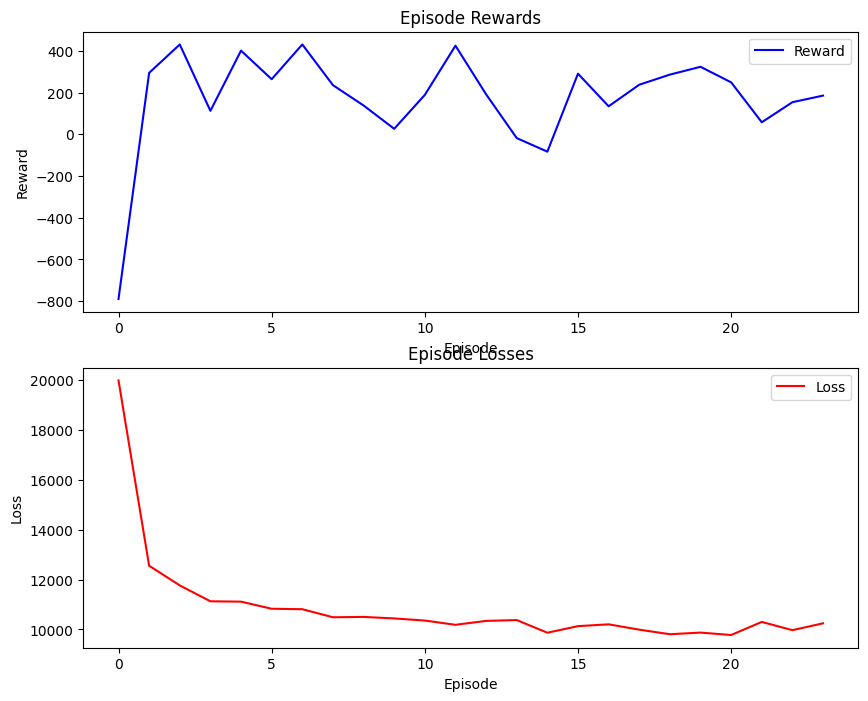

Episode 24: Total Reward = 185.7394212061442, Total Loss = 10243.635754346848


KeyboardInterrupt: 

In [11]:
# Initialize live plots for total rewards and total losses
plt.ion()
fig, (reward_ax, loss_ax) = plt.subplots(2, 1, figsize=(10, 8))

reward_ax.set_title("Episode Rewards")
reward_ax.set_xlabel("Episode")
reward_ax.set_ylabel("Reward")

loss_ax.set_title("Episode Losses")
loss_ax.set_xlabel("Episode")
loss_ax.set_ylabel("Loss")

reward_line, = reward_ax.plot([], [], label="Reward", color="blue")
loss_line, = loss_ax.plot([], [], label="Loss", color="red")

reward_ax.legend()
loss_ax.legend()


# Main training loop
episode_rewards = [] 
episode_losses = []

traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
for episode in range(NBR_EPISODES):
    # traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
    state = get_state()
    total_reward = 0
    total_loss = 0  # Initialize loss for this episode
    
    for step in range(STEPS_PER_EPISODE):
        # Choose & Take action A
        action = choose_action(state, EPSILON)
        take_action(action)
        traci.simulationStep()
        
        # Observe S' & R
        next_state = get_state()
        reward = calculate_reward(next_state)
        done = (step == STEPS_PER_EPISODE - 1)  # End of episode
        
        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        
        # Train the policy network
        loss = train()

        if loss is not None:
            total_loss += loss
        

        state = next_state
        total_reward += reward

        # # Update target network
        # if step % TARGET_UPDATE == 0:
        #     target_net.load_state_dict(policy_net.state_dict())
    


    # Update epsilon
    # epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    episode_rewards.append(total_reward)  # Append the total reward for the episode to the list
    episode_losses.append(total_loss)

    # # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    update_live_plots(fig, reward_ax, loss_ax, reward_line, loss_line, episode_rewards, episode_losses)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}, Total Loss = {total_loss}")
    # traci.close()
    
traci.close()

# Finalize the plot
plt.ioff()
plt.show()

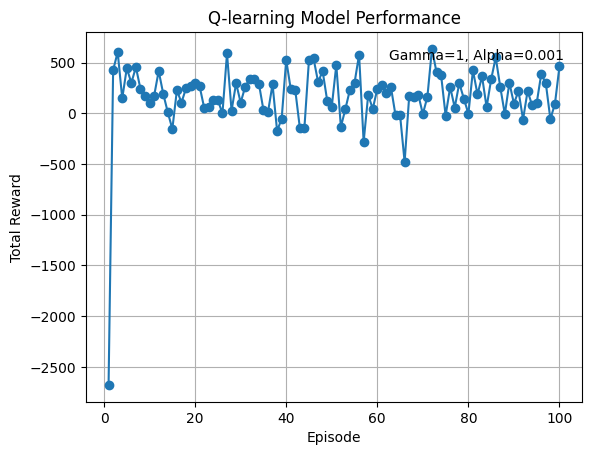

In [12]:
# Plot the episode rewards
nbr_run_episodes = len(episode_rewards) + 1
plt.plot(range(1, nbr_run_episodes), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}'#, Epsilon={EPSILON}'
plt.text(nbr_run_episodes, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()

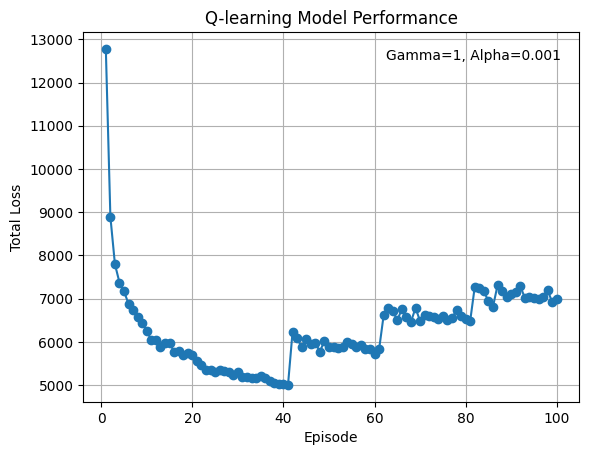

In [13]:
# Plot the episode losses
plt.plot(range(1, nbr_run_episodes), episode_losses, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Loss')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}'#, Epsilon={EPSILON}'
plt.text(nbr_run_episodes, max(episode_losses), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()

# Save the model

In [14]:
# Save Model
torch.save(policy_net, 'dqn_model.pth')


# # Saving and Loading the Model's State Dictionary (Recommended)
torch.save(policy_net.state_dict(), 'dqn_model_state_dict.pth')